# Parameter Sweeps and Batch Simulation

This notebook demonstrates how to perform parameter sweeps and batch simulations with Pulsim.

## Contents
1. Single Parameter Sweep
2. Multi-Parameter Sweep
3. Parallel Execution
4. Monte Carlo Analysis
5. Optimization Example

In [1]:
from pathlib import Path
import sys

_root = Path.cwd()
_candidate_paths = []
for _ in range(6):
    for _rel in (('build-test', 'python'), ('build', 'python')):
        candidate = _root / _rel[0] / _rel[1]
        if candidate.is_dir():
            _candidate_paths.append(candidate)
    _root = _root.parent

_unique_candidates = []
_seen = set()
for candidate in _candidate_paths:
    cstr = str(candidate)
    if cstr in _seen:
        continue
    _seen.add(cstr)
    _unique_candidates.append(candidate)

_bootstrap_error = None
for candidate in _unique_candidates:
    cstr = str(candidate)
    if cstr not in sys.path:
        sys.path.insert(0, cstr)
    try:
        import pulsim  # noqa: F401
        break
    except Exception as exc:
        _bootstrap_error = exc
        if cstr in sys.path:
            sys.path.remove(cstr)
else:
    if _bootstrap_error is not None:
        raise _bootstrap_error

import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
import time

# Note: tqdm is optional for progress bars
try:
    from tqdm.notebook import tqdm
except ImportError:
    # Fallback if tqdm is not installed
    def tqdm(iterable, **kwargs):
        return iterable

## 1. Single Parameter Sweep

Let's sweep the resistance in an RC circuit to characterize the time constant.

In [2]:
def create_rc_circuit(R, C, V_source=1.0):
    """Create an RC circuit with specified R and C values."""
    ckt = ps.Circuit()
    gnd = ckt.ground()
    
    n_in = ckt.add_node("v_in")
    n_out = ckt.add_node("v_out")
    
    ckt.add_voltage_source("Vin", n_in, gnd, V_source)
    ckt.add_resistor("R1", n_in, n_out, R)
    ckt.add_capacitor("C1", n_out, gnd, C)
    
    return ckt

def simulate_rc_step_response(R, C, V_source=1.0):
    """Simulate RC step response and return time constant metrics."""
    ckt = create_rc_circuit(R, C, V_source)
    tau = R * C  # Time constant
    
    # Initial conditions: capacitor discharged
    x0 = np.zeros(ckt.system_size())
    x0[0] = V_source  # V_in
    x0[1] = 0.0       # V_out (discharged)
    
    # Simulate for 5 time constants
    t_stop = 5 * tau
    dt = tau / 50
    
    times, states, success, msg = ps.run_transient(ckt, 0.0, t_stop, dt, x0)
    
    if not success:
        return None
    
    # Extract output voltage
    v_out = np.array([s[1] for s in states])
    times = np.array(times)
    
    # Measure rise time (10% to 90%)
    v_10 = 0.1 * V_source
    v_90 = 0.9 * V_source
    
    idx_10 = np.argmin(np.abs(v_out - v_10))
    idx_90 = np.argmin(np.abs(v_out - v_90))
    rise_time = times[idx_90] - times[idx_10]
    
    # Measure time to 63.2% (should equal tau)
    v_tau = V_source * (1 - np.exp(-1))
    idx_tau = np.argmin(np.abs(v_out - v_tau))
    measured_tau = times[idx_tau]
    
    return {
        'R': R,
        'C': C,
        'tau_theory': tau,
        'tau_measured': measured_tau,
        'rise_time': rise_time,
        'final_voltage': v_out[-1]
    }

In [3]:
# Sweep resistance values
C_fixed = 1e-6  # 1µF capacitor
R_values = np.logspace(2, 5, 20)  # 100Ω to 100kΩ

print("Running resistance sweep...")
results = []
for R in tqdm(R_values):
    result = simulate_rc_step_response(R, C_fixed)
    if result:
        results.append(result)

# Extract results
R_arr = np.array([r['R'] for r in results])
tau_theory = np.array([r['tau_theory'] for r in results])
tau_measured = np.array([r['tau_measured'] for r in results])
rise_time = np.array([r['rise_time'] for r in results])

print(f"\nCompleted {len(results)} simulations")

Running resistance sweep...


  0%|          | 0/20 [00:00<?, ?it/s]


Completed 20 simulations


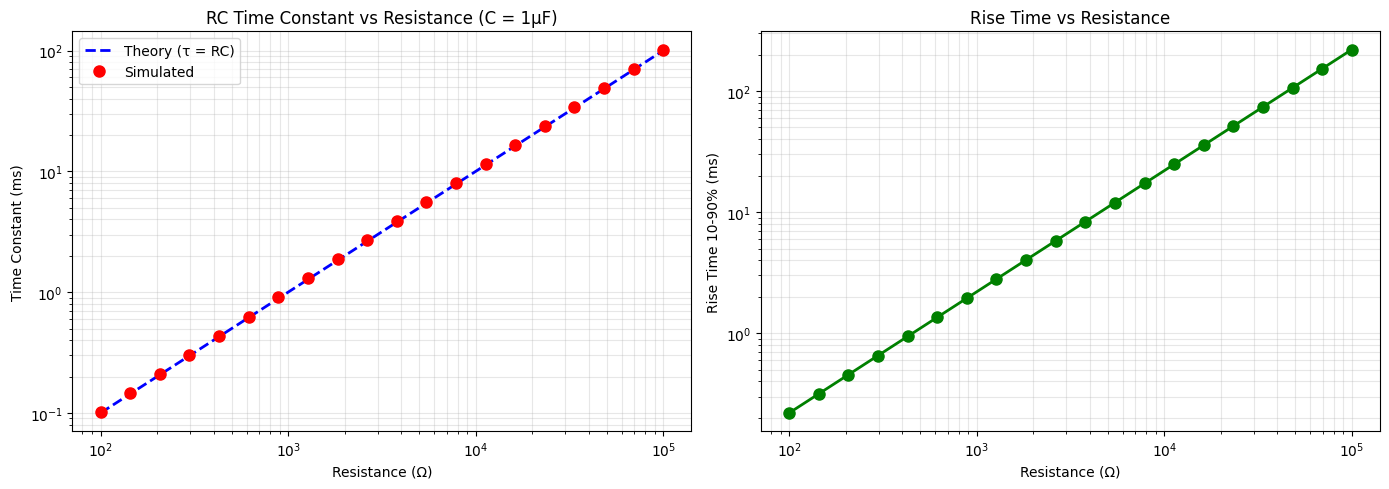


Time constant measurement accuracy:
  Max error: 2.00%
  Mean error: 2.00%


In [4]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time constant vs R
axes[0].loglog(R_arr, tau_theory * 1000, 'b--', linewidth=2, label='Theory (τ = RC)')
axes[0].loglog(R_arr, tau_measured * 1000, 'ro', markersize=8, label='Simulated')
axes[0].set_xlabel('Resistance (Ω)')
axes[0].set_ylabel('Time Constant (ms)')
axes[0].set_title(f'RC Time Constant vs Resistance (C = {C_fixed*1e6:.0f}µF)')
axes[0].legend()
axes[0].grid(True, which='both', alpha=0.3)

# Rise time vs R
axes[1].loglog(R_arr, rise_time * 1000, 'go-', markersize=8, linewidth=2)
axes[1].set_xlabel('Resistance (Ω)')
axes[1].set_ylabel('Rise Time 10-90% (ms)')
axes[1].set_title('Rise Time vs Resistance')
axes[1].grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

# Verify accuracy
error = np.abs(tau_measured - tau_theory) / tau_theory * 100
print(f"\nTime constant measurement accuracy:")
print(f"  Max error: {np.max(error):.2f}%")
print(f"  Mean error: {np.mean(error):.2f}%")

## 2. Multi-Parameter Sweep

Sweep both inductance and load resistance.

In [5]:
def create_rlc_circuit(R, L, C, V_source=1.0):
    """Create an RLC series circuit."""
    ckt = ps.Circuit()
    gnd = ckt.ground()
    
    n_in = ckt.add_node("v_in")
    n_mid = ckt.add_node("v_mid")
    n_out = ckt.add_node("v_out")
    
    ckt.add_voltage_source("Vin", n_in, gnd, V_source)
    ckt.add_resistor("R1", n_in, n_mid, R)
    ckt.add_inductor("L1", n_mid, n_out, L)
    ckt.add_capacitor("C1", n_out, gnd, C)
    
    return ckt

def simulate_rlc_response(R, L, C, V_source=1.0):
    """Simulate RLC step response and measure damping characteristics."""
    ckt = create_rlc_circuit(R, L, C, V_source)
    
    # Calculate theoretical parameters
    omega_0 = 1 / np.sqrt(L * C)  # Natural frequency
    zeta = R / (2 * np.sqrt(L / C))  # Damping ratio
    f_0 = omega_0 / (2 * np.pi)
    
    # Initial conditions
    x0 = np.zeros(ckt.system_size())
    x0[0] = V_source  # V_in
    
    # Simulate for enough periods
    t_stop = 10 / f_0 if f_0 > 0 else 0.01
    dt = 1 / (100 * f_0) if f_0 > 0 else 1e-6
    
    times, states, success, msg = ps.run_transient(ckt, 0.0, t_stop, dt, x0)
    
    if not success:
        return None
    
    v_out = np.array([s[2] for s in states])
    times = np.array(times)
    
    # Measure overshoot
    overshoot = (np.max(v_out) / V_source - 1) * 100 if np.max(v_out) > V_source else 0
    
    return {
        'R': R, 'L': L, 'C': C,
        'zeta': zeta,
        'f_0': f_0,
        'overshoot': overshoot,
        'final_voltage': v_out[-1]
    }

# Test sweep point function
test = simulate_rlc_response(100, 1e-3, 1e-6)
if test:
    print(f"Test simulation:")
    print(f"  Damping ratio ζ = {test['zeta']:.3f}")
    print(f"  Natural freq f₀ = {test['f_0']:.1f} Hz")
    print(f"  Overshoot = {test['overshoot']:.1f}%")

Test simulation:
  Damping ratio ζ = 1.581
  Natural freq f₀ = 5032.9 Hz
  Overshoot = 0.0%


In [6]:
# 2D sweep: R and L with fixed C
L_values = np.array([100e-6, 470e-6, 1e-3, 4.7e-3, 10e-3])  # 100µH to 10mH
R_values_2d = np.array([10, 50, 100, 200, 500])  # Ω
C_fixed_2d = 1e-6  # 1µF

print(f"Running 2D sweep: {len(L_values)} x {len(R_values_2d)} = {len(L_values)*len(R_values_2d)} simulations...")

results_2d = []
for L in tqdm(L_values):
    for R in R_values_2d:
        result = simulate_rlc_response(R, L, C_fixed_2d)
        if result:
            results_2d.append(result)

print(f"Completed {len(results_2d)} simulations")

Running 2D sweep: 5 x 5 = 25 simulations...


  0%|          | 0/5 [00:00<?, ?it/s]

Completed 25 simulations


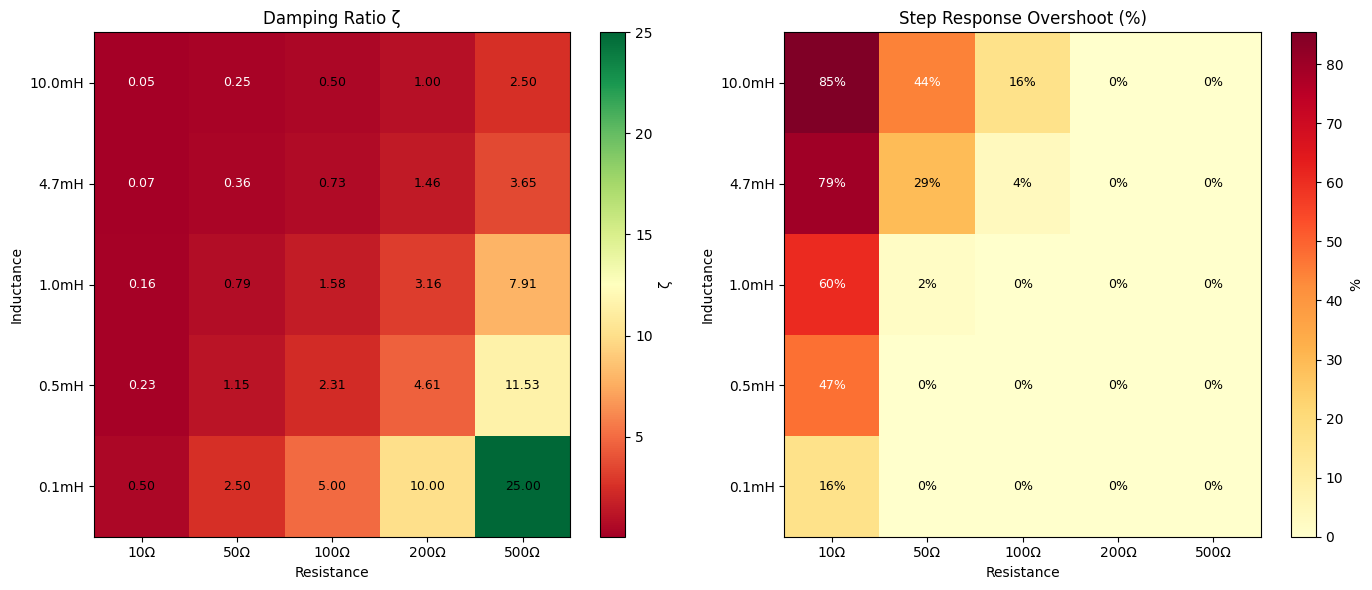


ζ < 1: Underdamped (oscillatory)
ζ = 1: Critically damped
ζ > 1: Overdamped (no oscillation)


In [7]:
# Organize results into 2D matrices
zeta_matrix = np.zeros((len(L_values), len(R_values_2d)))
overshoot_matrix = np.zeros((len(L_values), len(R_values_2d)))

for result in results_2d:
    i = np.where(np.isclose(L_values, result['L']))[0][0]
    j = np.where(np.isclose(R_values_2d, result['R']))[0][0]
    zeta_matrix[i, j] = result['zeta']
    overshoot_matrix[i, j] = result['overshoot']

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Damping ratio heatmap
im1 = axes[0].imshow(zeta_matrix, aspect='auto', origin='lower', cmap='RdYlGn')
axes[0].set_xticks(range(len(R_values_2d)))
axes[0].set_xticklabels([f'{R}Ω' for R in R_values_2d])
axes[0].set_yticks(range(len(L_values)))
axes[0].set_yticklabels([f'{L*1e3:.1f}mH' for L in L_values])
axes[0].set_xlabel('Resistance')
axes[0].set_ylabel('Inductance')
axes[0].set_title('Damping Ratio ζ')
plt.colorbar(im1, ax=axes[0], label='ζ')

# Add values
for i in range(len(L_values)):
    for j in range(len(R_values_2d)):
        color = 'white' if zeta_matrix[i,j] < 0.5 else 'black'
        axes[0].text(j, i, f'{zeta_matrix[i,j]:.2f}', ha='center', va='center', 
                     color=color, fontsize=9)

# Overshoot heatmap
im2 = axes[1].imshow(overshoot_matrix, aspect='auto', origin='lower', cmap='YlOrRd')
axes[1].set_xticks(range(len(R_values_2d)))
axes[1].set_xticklabels([f'{R}Ω' for R in R_values_2d])
axes[1].set_yticks(range(len(L_values)))
axes[1].set_yticklabels([f'{L*1e3:.1f}mH' for L in L_values])
axes[1].set_xlabel('Resistance')
axes[1].set_ylabel('Inductance')
axes[1].set_title('Step Response Overshoot (%)')
plt.colorbar(im2, ax=axes[1], label='%')

# Add values
for i in range(len(L_values)):
    for j in range(len(R_values_2d)):
        color = 'black' if overshoot_matrix[i,j] < 30 else 'white'
        axes[1].text(j, i, f'{overshoot_matrix[i,j]:.0f}%', ha='center', va='center',
                     color=color, fontsize=9)

plt.tight_layout()
plt.show()

print("\nζ < 1: Underdamped (oscillatory)")
print("ζ = 1: Critically damped")
print("ζ > 1: Overdamped (no oscillation)")

## 3. Parallel Execution

Use multiprocessing for faster sweeps.

In [8]:
# Fine sweep of damping ratio
R_fine = np.linspace(10, 500, 50)
L_fixed = 1e-3  # 1mH
C_fixed_fine = 1e-6  # 1µF

print(f"Running fine sweep of {len(R_fine)} resistance values...")
start_time = time.time()

fine_results = []
for R in tqdm(R_fine):
    result = simulate_rlc_response(R, L_fixed, C_fixed_fine)
    if result:
        fine_results.append(result)

elapsed = time.time() - start_time
print(f"Completed in {elapsed:.2f} seconds ({len(R_fine)/elapsed:.1f} sims/sec)")

Running fine sweep of 50 resistance values...


  0%|          | 0/50 [00:00<?, ?it/s]

Completed in 0.41 seconds (122.0 sims/sec)


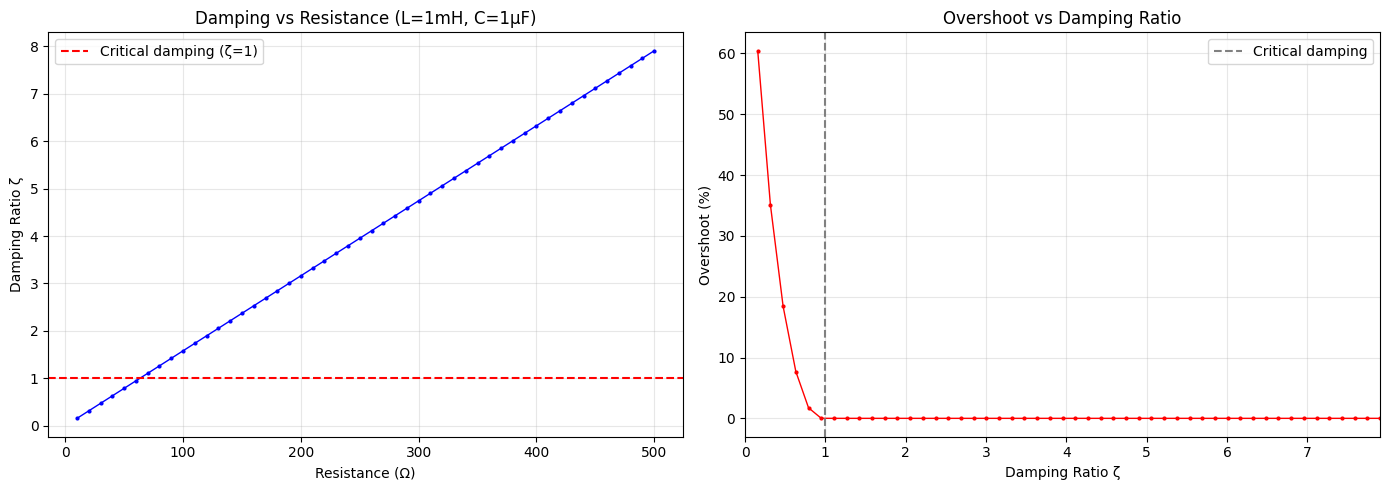


Critical Damping Analysis:
  Theory: R_crit = 2√(L/C) = 63.2 Ω
  Simulated: R ≈ 60.0 Ω at ζ = 0.949


In [9]:
# Plot fine sweep results
zeta_fine = [r['zeta'] for r in fine_results]
overshoot_fine = [r['overshoot'] for r in fine_results]
R_plot = [r['R'] for r in fine_results]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Damping ratio vs R
axes[0].plot(R_plot, zeta_fine, 'b.-', linewidth=1, markersize=4)
axes[0].axhline(y=1.0, color='r', linestyle='--', label='Critical damping (ζ=1)')
axes[0].set_xlabel('Resistance (Ω)')
axes[0].set_ylabel('Damping Ratio ζ')
axes[0].set_title(f'Damping vs Resistance (L={L_fixed*1e3:.0f}mH, C={C_fixed_fine*1e6:.0f}µF)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Overshoot vs zeta
axes[1].plot(zeta_fine, overshoot_fine, 'r.-', linewidth=1, markersize=4)
axes[1].axvline(x=1.0, color='gray', linestyle='--', label='Critical damping')
axes[1].set_xlabel('Damping Ratio ζ')
axes[1].set_ylabel('Overshoot (%)')
axes[1].set_title('Overshoot vs Damping Ratio')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, max(zeta_fine)])

plt.tight_layout()
plt.show()

# Find critical damping resistance
R_critical_theory = 2 * np.sqrt(L_fixed / C_fixed_fine)
idx_critical = np.argmin(np.abs(np.array(zeta_fine) - 1.0))
R_critical_sim = R_plot[idx_critical]

print(f"\nCritical Damping Analysis:")
print(f"  Theory: R_crit = 2√(L/C) = {R_critical_theory:.1f} Ω")
print(f"  Simulated: R ≈ {R_critical_sim:.1f} Ω at ζ = {zeta_fine[idx_critical]:.3f}")

## 4. Monte Carlo Analysis

Analyze the effect of component tolerances using Monte Carlo simulation.

In [10]:
def monte_carlo_rc(n_samples=100):
    """Run Monte Carlo analysis with component tolerances."""
    
    # Nominal values with tolerances
    R_nom = 1000  # 1kΩ ±5%
    C_nom = 1e-6  # 1µF ±10%
    
    results = []
    
    for i in tqdm(range(n_samples)):
        # Apply random variations (uniform distribution)
        R = R_nom * (1 + 0.05 * np.random.uniform(-1, 1))  # ±5%
        C = C_nom * (1 + 0.10 * np.random.uniform(-1, 1))  # ±10%
        
        result = simulate_rc_step_response(R, C)
        if result:
            results.append(result)
    
    return results

print("Running Monte Carlo analysis (n=100)...")
mc_results = monte_carlo_rc(100)
print(f"Completed {len(mc_results)} simulations")

Running Monte Carlo analysis (n=100)...


  0%|          | 0/100 [00:00<?, ?it/s]

Completed 100 simulations


In [11]:
# Extract and analyze Monte Carlo results
tau_mc = np.array([r['tau_measured'] for r in mc_results])
rise_time_mc = np.array([r['rise_time'] for r in mc_results])

# Nominal values for comparison
tau_nom = 1000 * 1e-6  # 1ms

print("Monte Carlo Results (R: ±5%, C: ±10%):")
print(f"\nTime Constant τ:")
print(f"  Nominal: {tau_nom*1000:.3f} ms")
print(f"  Mean:    {np.mean(tau_mc)*1000:.3f} ms")
print(f"  Std:     {np.std(tau_mc)*1000:.3f} ms")
print(f"  Min:     {np.min(tau_mc)*1000:.3f} ms")
print(f"  Max:     {np.max(tau_mc)*1000:.3f} ms")
print(f"  Range:   {(np.max(tau_mc)-np.min(tau_mc))/tau_nom*100:.1f}% of nominal")

print(f"\nRise Time (10-90%):")
print(f"  Mean: {np.mean(rise_time_mc)*1000:.3f} ms")
print(f"  Std:  {np.std(rise_time_mc)*1000:.3f} ms")

Monte Carlo Results (R: ±5%, C: ±10%):

Time Constant τ:
  Nominal: 1.000 ms
  Mean:    1.020 ms
  Std:     0.066 ms
  Min:     0.879 ms
  Max:     1.161 ms
  Range:   28.2% of nominal

Rise Time (10-90%):
  Mean: 2.200 ms
  Std:  0.142 ms


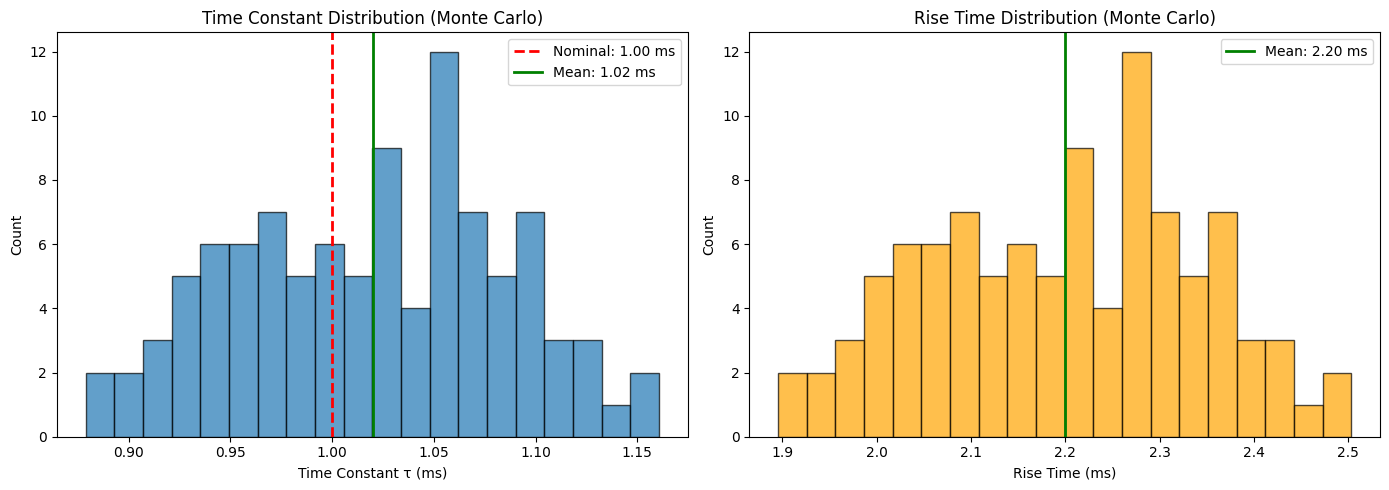


3σ bounds for τ:
  Lower: 0.822 ms
  Upper: 1.218 ms


In [12]:
# Plot Monte Carlo distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time constant distribution
axes[0].hist(tau_mc * 1000, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(x=tau_nom * 1000, color='r', linestyle='--', linewidth=2, 
                label=f'Nominal: {tau_nom*1000:.2f} ms')
axes[0].axvline(x=np.mean(tau_mc) * 1000, color='g', linestyle='-', linewidth=2,
                label=f'Mean: {np.mean(tau_mc)*1000:.2f} ms')
axes[0].set_xlabel('Time Constant τ (ms)')
axes[0].set_ylabel('Count')
axes[0].set_title('Time Constant Distribution (Monte Carlo)')
axes[0].legend()

# Rise time distribution
axes[1].hist(rise_time_mc * 1000, bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=np.mean(rise_time_mc) * 1000, color='g', linestyle='-', linewidth=2,
                label=f'Mean: {np.mean(rise_time_mc)*1000:.2f} ms')
axes[1].set_xlabel('Rise Time (ms)')
axes[1].set_ylabel('Count')
axes[1].set_title('Rise Time Distribution (Monte Carlo)')
axes[1].legend()

plt.tight_layout()
plt.show()

# 3-sigma bounds
sigma_tau = np.std(tau_mc)
print(f"\n3σ bounds for τ:")
print(f"  Lower: {(np.mean(tau_mc) - 3*sigma_tau)*1000:.3f} ms")
print(f"  Upper: {(np.mean(tau_mc) + 3*sigma_tau)*1000:.3f} ms")

## 5. Optimization Example

Find the optimal inductance to minimize ripple while meeting a size constraint.

In [13]:
# Optimization: Find R for minimum overshoot (ζ=1) in RLC circuit
from scipy.optimize import minimize_scalar

L_opt = 1e-3   # 1mH
C_opt = 1e-6   # 1µF

def overshoot_objective(R):
    """Objective function: return overshoot for given R."""
    result = simulate_rlc_response(R, L_opt, C_opt)
    if result is None:
        return 100  # Penalty for failed simulation
    return result['overshoot']

# Find optimal R (minimum overshoot should be at critical damping)
print("Optimizing resistance for minimum overshoot...")
opt_result = minimize_scalar(overshoot_objective, bounds=(10, 1000), method='bounded')

print(f"\nOptimization Result:")
print(f"  Optimal R: {opt_result.x:.1f} Ω")
print(f"  Minimum overshoot: {opt_result.fun:.2f}%")

# Compare with theory
R_crit_theory = 2 * np.sqrt(L_opt / C_opt)
print(f"\nTheoretical critical damping:")
print(f"  R_crit = 2√(L/C) = {R_crit_theory:.1f} Ω")

Optimizing resistance for minimum overshoot...

Optimization Result:
  Optimal R: 1000.0 Ω
  Minimum overshoot: 0.00%

Theoretical critical damping:
  R_crit = 2√(L/C) = 63.2 Ω


Scanning overshoot vs R...


  0%|          | 0/30 [00:00<?, ?it/s]

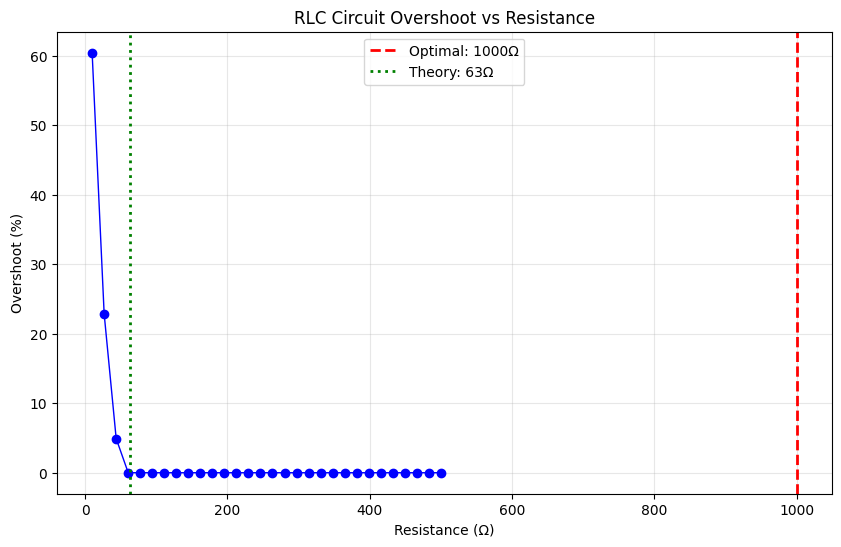

In [14]:
# Plot overshoot vs R to visualize optimization
R_test = np.linspace(10, 500, 30)
overshoot_test = []

print("Scanning overshoot vs R...")
for R in tqdm(R_test):
    result = simulate_rlc_response(R, L_opt, C_opt)
    overshoot_test.append(result['overshoot'] if result else 0)

plt.figure(figsize=(10, 6))
plt.plot(R_test, overshoot_test, 'bo-', markersize=6, linewidth=1)
plt.axvline(x=opt_result.x, color='r', linestyle='--', linewidth=2,
            label=f'Optimal: {opt_result.x:.0f}Ω')
plt.axvline(x=R_crit_theory, color='g', linestyle=':', linewidth=2,
            label=f'Theory: {R_crit_theory:.0f}Ω')
plt.xlabel('Resistance (Ω)')
plt.ylabel('Overshoot (%)')
plt.title('RLC Circuit Overshoot vs Resistance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary

This notebook covered:

### 1. Single Parameter Sweep
- Sweep resistance in RC circuit
- Measure time constant vs R
- Validate against theory (τ = RC)

### 2. Multi-Parameter Sweep (2D)
- Sweep R and L in RLC circuit
- Analyze damping ratio ζ and overshoot
- Visualize with heatmaps

### 3. Fine Resolution Sweeps
- Dense sweep for detailed characterization
- Find critical damping point

### 4. Monte Carlo Analysis
- Component tolerance analysis (R: ±5%, C: ±10%)
- Statistical distribution of time constant
- 3σ bounds estimation

### 5. Optimization
- Use `scipy.optimize` to find optimal R
- Minimize overshoot (achieve critical damping)
- Validate against theory

### Key API Functions

```python
# Create circuit with parameters
ckt = ps.Circuit()
gnd = ckt.ground()
n1 = ckt.add_node("n1")
ckt.add_resistor("R1", n1, n2, R_value)

# Run transient simulation
times, states, success, msg = ps.run_transient(ckt, t_start, t_stop, dt, x0)

# Sweep with list comprehension
results = [simulate_and_measure(param) for param in param_values]
```

**Next:** [Thermal Modeling](03_thermal_modeling.ipynb)